# **Handling digital pathology image(WSI, Whole Slide Image)**
본 "Handling digital pathology" 실습은 
digital pathology image를 딥러닝에 적용하기에 앞서  
간단한 patho image handling을 다룹니다.  
실습에 앞서 필요한 데이터와 라이브러리를 내려받습니다.  
라이브러리를 모두 받은 후에 꼭 **[런타임]-[런타임 다시 시작]**을 눌러주세요.

In [ ]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MMZMfZc1MBW3jjiRlS_Kc6XNgc7VNmeX' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MMZMfZc1MBW3jjiRlS_Kc6XNgc7VNmeX" -O wsi.zip && rm -rf ~/cookies.txt

In [ ]:
!unzip wsi.zip -d ./wsi

In [ ]:
!apt-get install python3-openslide

In [ ]:
!pip install imagecodecs

## Opening

- Step 1. Whole Slide Image(WSI)
- Step 2. svs 파일 불러오기: OpenSlide
- Step 3. WSI 해상도
- Step 4. WSI 특성: FOV ~ micrometer per pixel(mpp)
- Step 5. WSI 영상 불러오기
- Step 6. TIFF로 저장하기
- Step 7. WSI patches generation

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL.Image as Image
import tifffile as tiff

In [ ]:
!pwd

## Step 1. Whole Slide Image(WSI)
디지털 병리학에 대한 폭넓은 정의는, 유리로 된 병리 슬라이드를 디지털 영상(‘디지털 슬라이드’)으로 변환하고   
이것을 활용함으로써 기존의 병리 작업흐름에 개선과 혁신을 가져오는 것에 관계된 모든 기술을 통칭합니다.   
디지털 병리학을 실현하는 핵심 기술인 ‘Whole Slide Imaging (WSI)’은 전체 현미경 슬라이드를 스캔하여  
단일 고해상도 디지털 파일로 변환하는 것을 말합니다.

![WSI](https://www.researchgate.net/publication/320511493/figure/fig3/AS:551352443076609@1508464074378/A-digital-pathology-whole-slide-image-The-20-000-14-000-whole-slide-image-is-shown-on.png)

## Step 2. svs 파일 불러오기: OpenSlide
WSI는 벤더 회사마다 다른 확장자를 갖습니다.  
본 실습에서는 그 중 svs 파일의 WSI를 다룹니다.  
svs 확장자의 whole slide image는 OpenSlide 라이브러리를 이용해 열 수 있습니다.  
https://openslide.org/  

![openslide_logo](https://openslide.org/images/openslide_logo.png)

data reference:   
https://data.mendeley.com/datasets/k7nvtgn2x6/3  
(Data for glomeruli characterization in histopathological images)

In [ ]:
DATA_PATH = './wsi'

In [ ]:
# Load .svs file paths
svs_path = os.path.join(DATA_PATH, 'SAS_21883_001.svs')
svs_path

In [ ]:
# Read .svs file
import openslide # OpenSlide: to read whole-slide images

In [ ]:
# OpenSlide instance
wsi_slide = openslide.OpenSlide(svs_path)

## Step 3. WSI 해상도
WSI 해상도는 원본이 level 0로,  
n level은 원본의 2<sup>-n</sup>으로 해상도가 낮아집니다.  
OpenSlide 인스턴스의 level_dimensions는  
WSI에 저장되어 있는 level들의 해상도가 tuple 형태로 있습니다.

![wsi_resolution_level](https://slideplayer.com/slide/11404136/42/images/88/WSI+file+pyramid+structure.jpg)

In [ ]:
# level_dimensions는 WSI에 저장되어 있는 level들의 해상도가 tuple 형태로 있습니다.
print('-'*50)
dim_level_0 = wsi_slide.level_dimensions[0]
print(f'level 0 dimensions (width,height): \t{dim_level_0}')
print('-'*50)
dim_level_2 = wsi_slide.level_dimensions[1]
print(f'level 2 dimensions (width,height): \t{dim_level_2}')
print(f'level 0 dimensions divided by 4: \t{(int(dim_level_0[0]/4), int(dim_level_0[1]/4))}')
print('-'*50)
dim_level_4 = wsi_slide.level_dimensions[2]
print(f'level 3 dimensions (width,height): \t{dim_level_4}')
print(f'level 0 dimensions divided by 8:  \t{(int(dim_level_0[0]/8), int(dim_level_0[1]/8))}')
print('-'*50)

In [ ]:
# match dimension level with list index { level : list index }
LEVEL_IDX = {
    'level0' : 0,
    'level2' : 1,
    'level3' : 2,  
}

## Step 4. WSI 특성: FOV ~ micron per pixel(mpp)

OpenSlide 인스턴스의 properties에는 WSI 영상의 특성이 dictionary 형태로 저장되어 있습니다.  
WSI 특성 중 mpp를 활용하여 WSI patch의 FOV를 구할 수 있습니다.  
**mpp: micron per pixel로 1 pixel에 대응되는 실제 크기(micron)

In [ ]:
wsi_slide.properties

In [ ]:
print("x-axis mpp: ", wsi_slide.properties["openslide.mpp-x"])
print("y-axis mpp: ", wsi_slide.properties["openslide.mpp-y"])

In [ ]:
patch_size = (512, 512) # (x, y)
print("patch size:\t", patch_size)
print("Horizontal FOV:\t", patch_size[0]*float(wsi_slide.properties["openslide.mpp-x"])," um") 
print("Vertical FOV:\t", patch_size[1]*float(wsi_slide.properties["openslide.mpp-y"])," um")

## Step 5. WSI 영상 불러오기
OpenSlide 클래스의 `read_region` 메서드를 통해 원하는 level의 영상을 불러올 수 있습니다.  
read_region 메서드는 세가지 parameter를 설정해줘야합니다.
- location: level0 기준으로 불러올 영상의 시작 좌표값 (x 좌표, y 좌표)  
(이 때, x좌표의 0은 왼쪽 y좌표의 0은 상단입니다.)
- level: 해상도 level index(level_dimensions)
- size: 불러올 영상 크기 (width, height)

level0의 전체 영상을 읽고 싶은 경우,
- location: (0,0)
- level: 0
- size: level 0에서의 영상 크기

In [ ]:
# visualize WSI at level 3
dim_level_3 = wsi_slide.level_dimensions[LEVEL_IDX['level3']]
print(dim_level_3) # (x, y) 

#read_region(location, level, size)
# location ; size: x, y(coordinate matplotlib 기준) ; width, height
wsi_array_level3 = np.array(wsi_slide.read_region([0,0], LEVEL_IDX['level3'], [dim_level_3[0], dim_level_3[1]]))[:,:,0:3] #rgba(red,green,blue,alpha) ~ rgb
print(wsi_array_level3.shape) #(row, column, rgb) matrix

plt.figure(figsize=(15,15))
plt.imshow(wsi_array_level3)
plt.title(os.path.splitext(os.path.basename(svs_path))[0])

In [ ]:
# level-wise resolution in patch size 512x512
patch_size = (512, 512)
dim_level_0 = wsi_slide.level_dimensions[LEVEL_IDX['level0']]
dim_level_2 = wsi_slide.level_dimensions[LEVEL_IDX['level2']]
dim_level_3 = wsi_slide.level_dimensions[LEVEL_IDX['level3']]

wsi_patch_level0 = np.array(wsi_slide.read_region([2700,3000], LEVEL_IDX['level0'], patch_size))[:,:,0:3]
wsi_patch_level2 = np.array(wsi_slide.read_region([2500,2500], LEVEL_IDX['level2'], patch_size))[:,:,0:3]
wsi_patch_level3 = np.array(wsi_slide.read_region([1250,1250], LEVEL_IDX['level3'], patch_size))[:,:,0:3]

fig,ax = plt.subplots(1,3,figsize=[18,20])
ax[0].imshow(wsi_patch_level0)
ax[0].set_title("level0 512x512 patch")
ax[1].imshow(wsi_patch_level2)
ax[1].set_title("level2 512x512 patch")
ax[2].imshow(wsi_patch_level3)
ax[2].set_title("level3 512x512 patch")

만약 level_dimensions에 없는 해상도를 사용하고자 하는 경우  
level 0 영상을 resize하는 방법이 있습니다.

In [65]:
# # cv2.resize and openslide level_dimensions ~ not exactly same
# dim_level_0 = wsi_slide.level_dimensions[LEVEL_IDX['level0']]
# wsi_array_level0 = np.array(wsi_slide.read_region([0,0], LEVEL_IDX['level0'], [dim_level_0[0], dim_level_0[1]]))[:,:,0:3]
# wsi_array_level2_cv2 = cv2.resize(
#                             wsi_array_level0,
#                             (wsi_array_level0.shape[1] // 4, wsi_array_level0.shape[0] // 4),
#                             interpolation=cv2.INTER_AREA,
#                             )
# plt.figure(figsize=(15,15))
# plt.imshow(wsi_array_level2_cv2)
# plt.title(sample_path)

## Step 6. TIFF로 저장하기
편의를 위해 svs 파일을 tiff 파일로 변환하는 작업을 해줍니다.

In [56]:
# def save_svs_to_tiff(svs_path, level, save_dir):
#     fname = os.path.splitext(os.path.basename(svs_path))[0]
#     save_path = os.path.join(save_dir, fname+'.tiff')
#     wsi_slide = openslide.OpenSlide(svs_path)
#     dim_level_0 = wsi_slide.level_dimensions[LEVEL_IDX['level0']]
#     wsi_array_level0 = np.array(wsi_slide.read_region([0,0], LEVEL_IDX['level0'], [dim_level_0[0], dim_level_0[1]]))[:,:,0:3]
#     downsample_factor = 2**level
#     wsi_array_downsampled = cv2.resize(
#                             wsi_array_level0,
#                             (wsi_array_level0.shape[1] // downsample_factor, 
#                              wsi_array_level0.shape[0] // downsample_factor),
#                             interpolation=cv2.INTER_AREA,
#                             )
#     #cv2.imwrite(save_path, wsi_array_downsampled) #
#     Image.fromarray(wsi_array_downsampled).save(save_path) # cv2.imwrite는 권장하지 않음
#     print(f"saved wsi to {save_path}")

In [57]:
# save_dir = os.path.join(DATA_PATH, 'level4')
# try: 
#     if not os.path.exists(save_dir): 
#         os.makedirs(save_dir) 
#         print(f"New directory!: {save_dir}")
# except OSError: 
#     print("Error: Failed to create the directory.")

In [58]:
# save_svs_to_tiff(svs_path, 4, save_dir)

saved wsi to ./data/patho/level4/SAS_21883_001.tiff


In [54]:
# tiff_path = "./wsi/level4/SAS_21883_001.tiff"
# tiff_slide = np.array(Image.open(tiff_path)) #tiff.imread(tiff_path)

Text(0.5, 1.0, './data/patho/level2/SAS_21883_001.tiff')

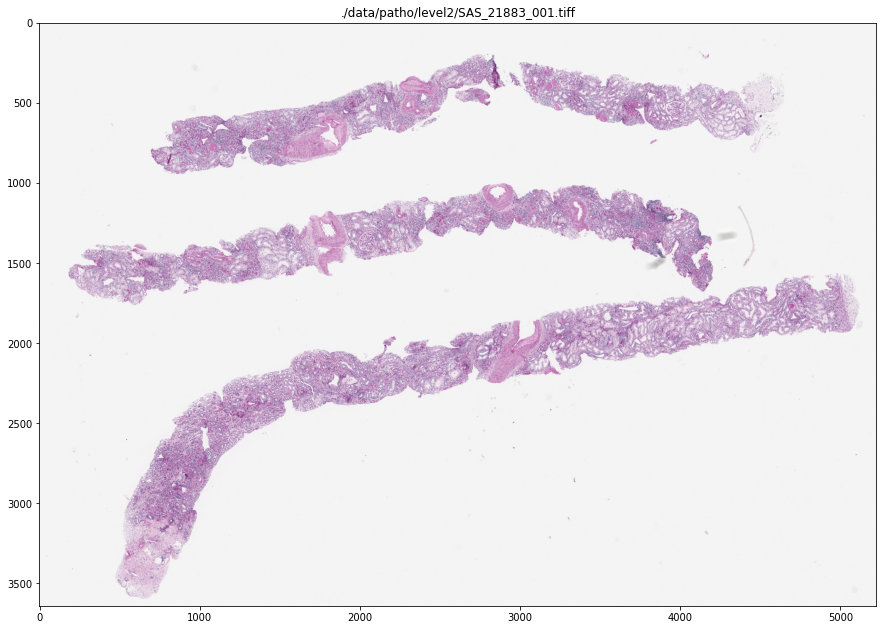

In [55]:
# plt.figure(figsize=(15,15))
# plt.imshow(tiff_slide)
# plt.title(tiff_path)

## Step 7. WSI patches generation
디지털 병리 영상은 다른 의료 영상에 비해 해상도가 높습니다.  
영상이 매우 크기 때문에 전체 영상을 한번에 딥러닝 모델에 학습하는데 한계가 있습니다.  
병리 영상은 모델 학습 시 영상을 일정 patch 사이즈로 나누어 학습하는 것이 일반적입니다.  
reference: https://www.kaggle.com/mariazorkaltseva/hubmap-train-test-patches-generation

In [ ]:
TILE_SIZE = 256 #patch size
REDUCE_RATE = 4 #1/n resolution: level2
SAVE_DIR = "./wsi/wsi_tiles/"

In [ ]:
def extract_tiles(sample_img_path, idx):
    """downsampling image and extract tiles with downsampled image
    """
    sample_image = tiff.imread(sample_img_path)
    print(f"Original Tiff image shape: {sample_image.shape}")
    
    #get padding size
    pad0 = (REDUCE_RATE*TILE_SIZE - sample_image.shape[0]%(REDUCE_RATE*TILE_SIZE))%(REDUCE_RATE*TILE_SIZE)
    pad1 = (REDUCE_RATE*TILE_SIZE - sample_image.shape[1]%(REDUCE_RATE*TILE_SIZE))%(REDUCE_RATE*TILE_SIZE)
    
    #pad image
    sample_image = np.pad(sample_image,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                   constant_values=0)
    
    #resize image with REDUCE_RATE
    sample_image = cv2.resize(sample_image,(sample_image.shape[1]//REDUCE_RATE,sample_image.shape[0]//REDUCE_RATE),
                             interpolation = cv2.INTER_AREA)
    
    print(f"Reduced Tiff image shape: {sample_image.shape}")
    
    tiles= []
    for x in range(0,sample_image.shape[0],TILE_SIZE):
        for y in range(0,sample_image.shape[1],TILE_SIZE):
            sub_image = np.float32(sample_image[x:x+TILE_SIZE,y:y+TILE_SIZE])
            tiles.append(sub_image)
            
    if not os.path.exists(SAVE_DIR):
        os.mkdir(SAVE_DIR)
    if not os.path.exists(os.path.join(SAVE_DIR, idx)):
        os.mkdir(os.path.join(SAVE_DIR, idx))

    count = 0
    for tile in tiles:
        cv2.imwrite(os.path.join(SAVE_DIR, idx, f"img_{count:03}.png"), tile)

        count += 1
            
    print(f"Length tiles", len(tiles))
    #gc.collect()

In [ ]:
extract_tiles(svs_path, '0')

In [ ]:
tile_path_ls = glob.glob('./wsi/wsi_tiles/0/*')
tile_path_ls = [file for file in tile_path_ls if file.endswith(".png")]
tile_path_ls.sort()

In [ ]:
tile_img_ls = [np.array(Image.open(p)) for p in tile_path_ls]

In [ ]:
def sample_stack(stack, rows=6, cols=6, start_with=30, show_every=1, vmin=0, vmax=255):
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title(f'patch {ind}')
        ax[int(i/cols),int(i % cols)].imshow(stack[ind], vmin=vmin, vmax=vmax,cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

In [ ]:
sample_stack(tile_img_ls)